### Simple Moving-Average model

We now turn to another class of simple models that are also useful in modeling return series in finance. These models are called moving-average (MA) models. There are several ways to introduce MA models. One approach is to treat the model as a simple extension of white noise series. Another approach is to treat the model as an infinite-order AR model with some parameter constraints. We adopt the second approach.

In [1]:
import pandas as pd
import numpy as np
import efinance as ef
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/home/pku/zhaoyz/anaconda3/envs/quant/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 628.063
Date:                Mon, 14 Apr 2025   AIC                          -1248.127
Time:                        13:55:07   BIC                          -1234.934
Sample:                    01-01-2020   HQIC                         -1242.788
                         - 07-18-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.181      0.238      -0.001       0.003
ma.L1          0.4566      0.071      6.436      0.000       0.318       0.596
ma.L2         -0.2391      0.076     -3.146      0.0

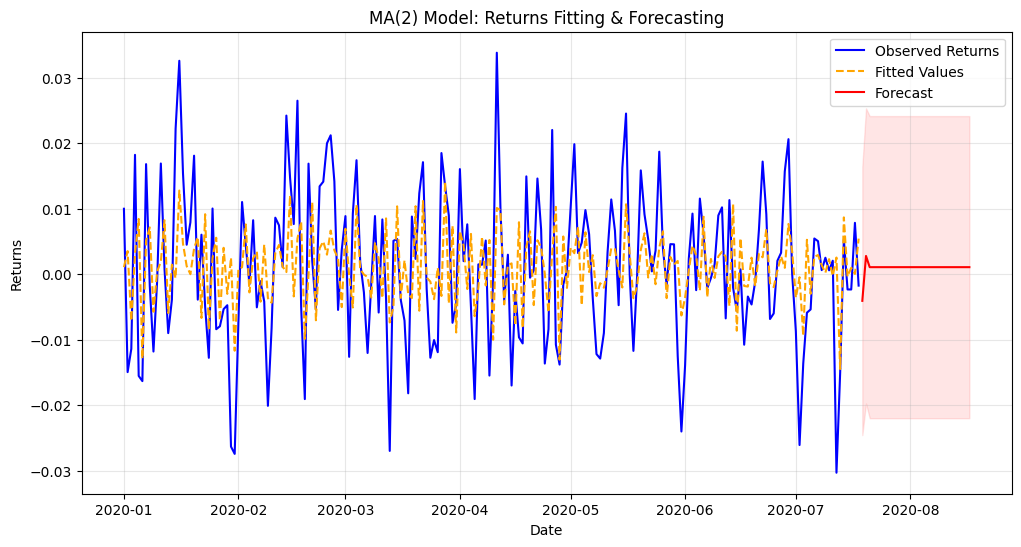

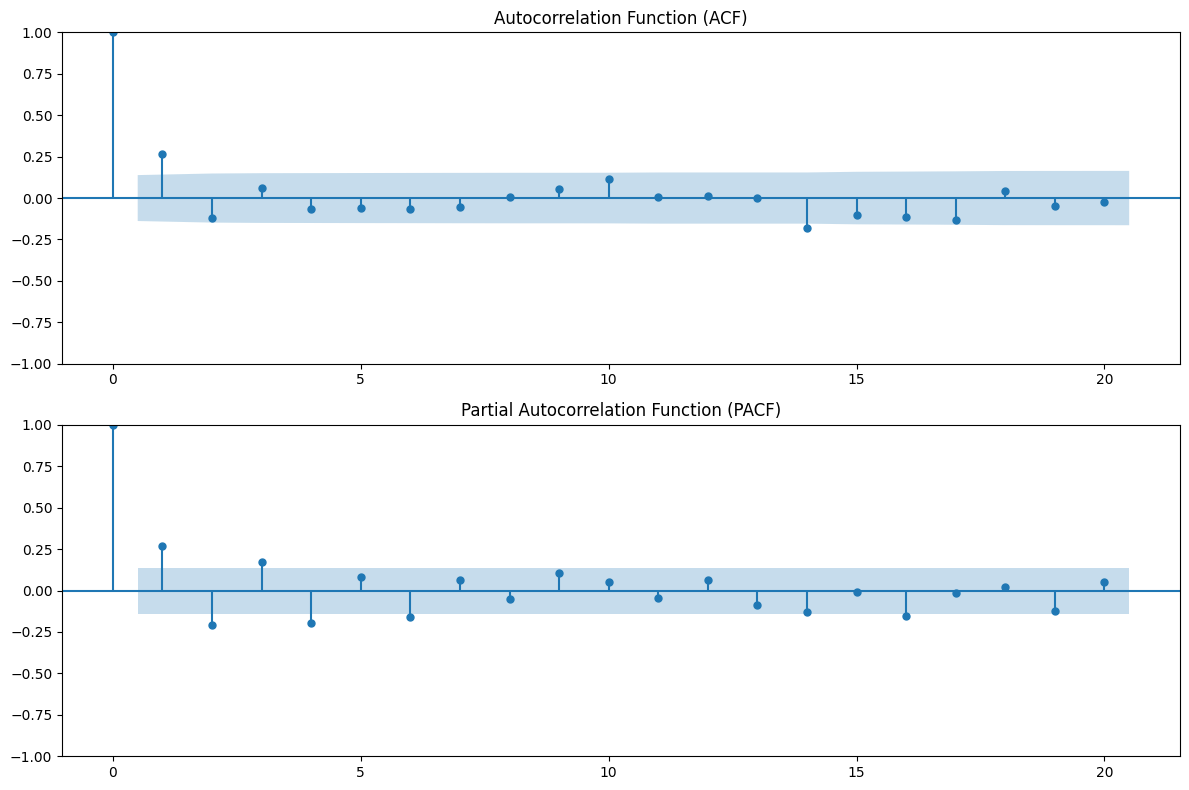

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import yfinance as yf  # 可选：获取真实股票数据

# ----------------------
# 1. 生成或加载股票回报率数据
# ----------------------

# 方法1：模拟数据（若没有真实数据）
np.random.seed(123)
n = 200  # 数据长度
mu = 0.001  # 均值
theta = [0.4, -0.2]  # MA(2) 参数 [θ1, θ2]
p = len(theta)  # MA阶数

# 生成白噪声
epsilon = np.random.normal(0, 0.01, n + p)  # 多生成p期避免初始值问题

# 生成MA(p)序列
returns = np.zeros(n)
for t in range(p, n + p):
    returns[t - p] = mu + epsilon[t] + sum([theta[i] * epsilon[t - i - 1] for i in range(p)])

dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
data = pd.Series(returns, index=dates)

# 方法2：下载真实股票数据（示例用苹果股票）
# data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')['Adj Close']
# data = data.pct_change().dropna()  # 计算日收益率并去NaN


# ----------------------
# 2. 拟合MA(p)模型
# ----------------------
p = 2  # 指定MA阶数（可改为1,2,3...）
model = ARIMA(data, order=(0, 0, p))  # ARIMA(0,0,p) 即MA(p)
results = model.fit()

# 输出模型摘要
print(results.summary())


# ----------------------
# 3. 预测未来数据
# ----------------------
forecast_steps = 30  # 预测未来30期
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


# ----------------------
# 4. 绘制结果
# ----------------------
plt.figure(figsize=(12, 6))

# 绘制历史数据
plt.plot(data.index, data, label='Observed Returns', color='blue')

# 绘制拟合值（注意：MA模型拟合值为一步向前预测）
fitted_values = results.fittedvalues
plt.plot(fitted_values.index, fitted_values, label='Fitted Values', color='orange', linestyle='--')

# 绘制预测值
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:]
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.1)

# 图表装饰
plt.title(f'MA({p}) Model: Returns Fitting & Forecasting')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# ----------------------
# 可选：绘制ACF和PACF诊断图
# ----------------------
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, lags=20, ax=ax1, title='Autocorrelation Function (ACF)')
plot_pacf(data, lags=20, ax=ax2, title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

可以看到，在两步之后，预测值即变成了一条水平的直线，这是合理的。

 the multistep ahead forecasts of an MA(2) model go to the mean of the series after two steps. The variances of forecast errors go to the variance of the series after two steps. 

 In general, for an MA(q) model, multistep ahead forecasts go to the mean after the first q steps.

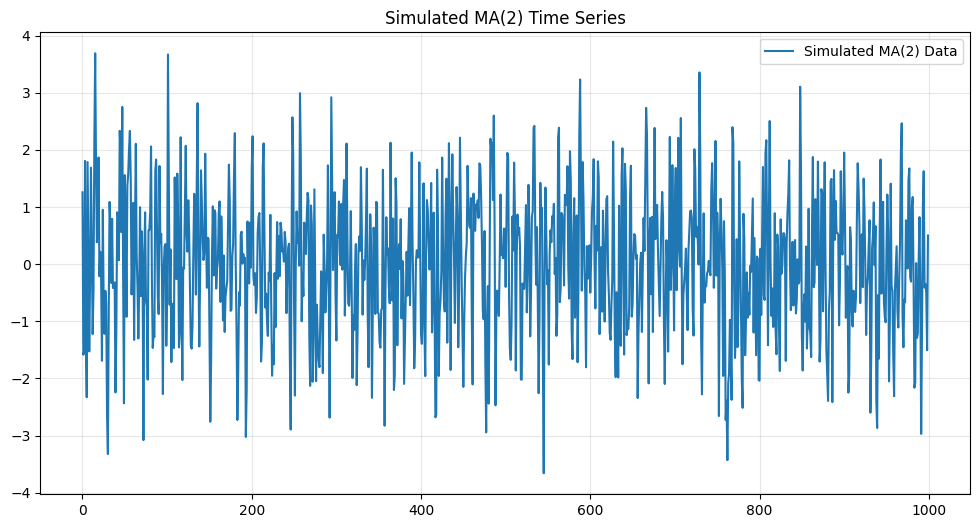

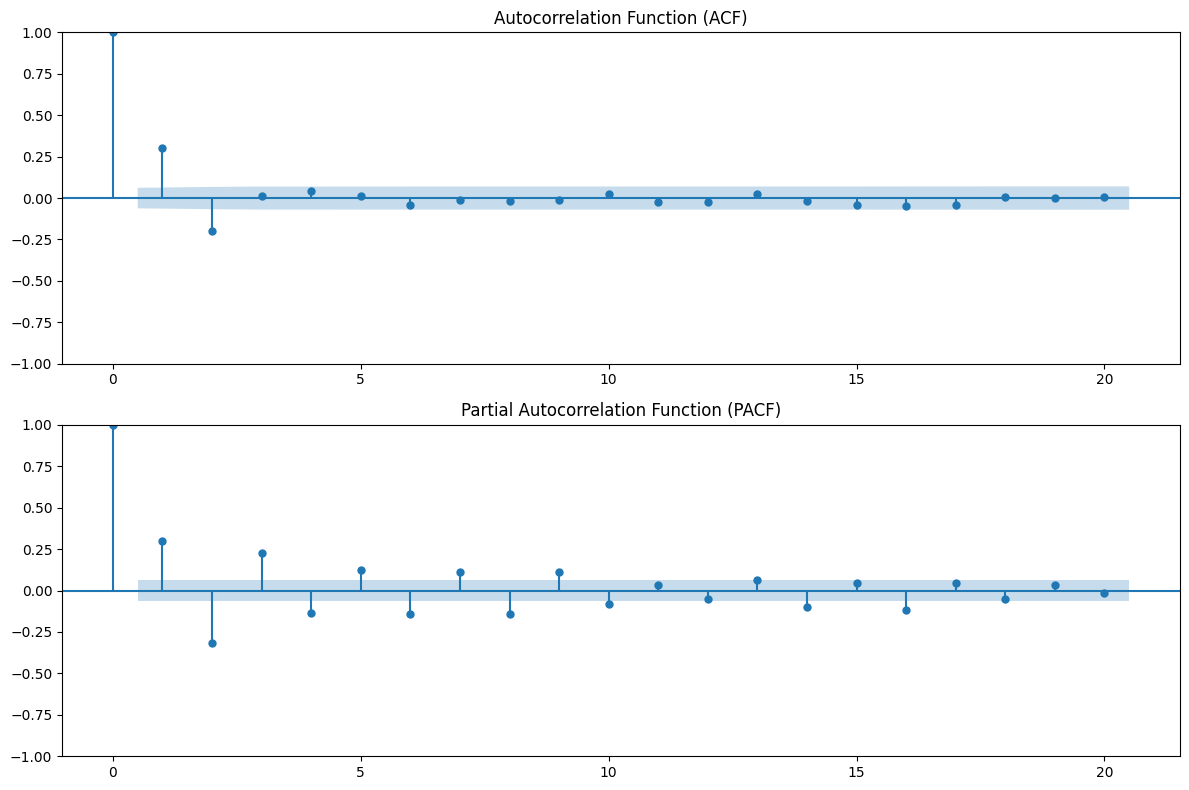


MA(1)模型结果:
                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1460.347
Date:                Mon, 14 Apr 2025   AIC                           2926.695
Time:                        14:01:43   BIC                           2941.418
Sample:                             0   HQIC                          2932.290
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.062      0.009      0.993      -0.122       0.123
ma.L1          0.8888      0.015     59.444      0.000       0.859       0.918
sigma2         1.0846      0.049     22.

/tmp/ipykernel_3067233/2320103950.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  μ: {results_ma1.params[0]:.4f}")


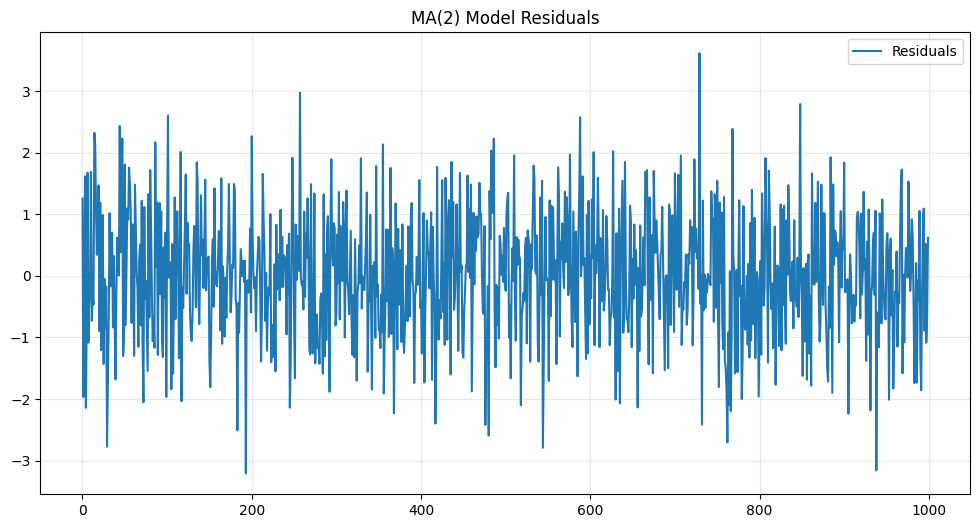

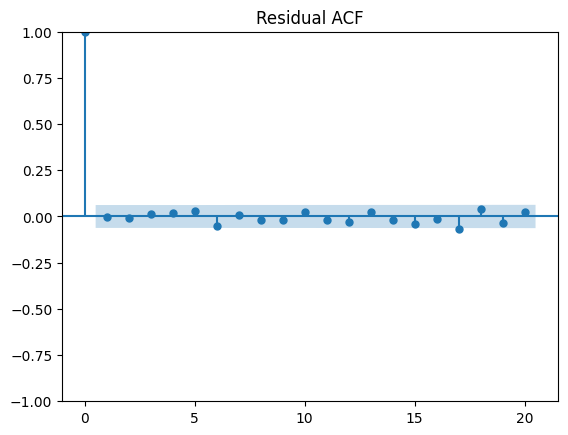

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ----------------------
# 1. 生成模拟的MA(2)数据（假设真实模型为MA(2)）
# ----------------------
np.random.seed(123)  # 固定随机种子
n = 1000  # 数据长度
mu = 0.05  # 均值
theta_true = [0.6, -0.3]  # MA(2)的真实参数 [θ1, θ2]

# 生成白噪声序列
epsilon = np.random.normal(0, 1, n + 2)  # 多生成2期避免初始值问题

# 生成MA(2)序列
data = np.zeros(n)
for t in range(2, n + 2):
    data[t-2] = mu + epsilon[t] + theta_true[0]*epsilon[t-1] + theta_true[1]*epsilon[t-2]

data = pd.Series(data, name="Returns")  # 转换为Pandas Series

# ----------------------
# 2. 可视化原始数据及其ACF/PACF
# ----------------------
plt.figure(figsize=(12, 6))
plt.plot(data, label="Simulated MA(2) Data")
plt.title("Simulated MA(2) Time Series")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 绘制ACF和PACF图（帮助确定MA阶数）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, lags=20, ax=ax1, title="Autocorrelation Function (ACF)")
plot_pacf(data, lags=20, ax=ax2, title="Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

# ----------------------
# 3. 拟合MA(1)和MA(2)模型
# ----------------------
# 拟合MA(1)
model_ma1 = ARIMA(data, order=(0, 0, 1))  # ARIMA(0,0,1)即MA(1)
results_ma1 = model_ma1.fit()

# 拟合MA(2)
model_ma2 = ARIMA(data, order=(0, 0, 2))  # ARIMA(0,0,2)即MA(2)
results_ma2 = model_ma2.fit()

# ----------------------
# 4. 输出模型结果
# ----------------------
print("\nMA(1)模型结果:")
print(results_ma1.summary())

print("\nMA(2)模型结果:")
print(results_ma2.summary())

# ----------------------
# 5. 比较真实参数与估计参数
# ----------------------
print(f"\n真实参数: μ={mu}, θ1={theta_true[0]}, θ2={theta_true[1]}")
print("MA(1)估计参数:")
print(f"  μ: {results_ma1.params[0]:.4f}")
print(f"  θ1: {results_ma1.params[1]:.4f}")

print("\nMA(2)估计参数:")
print(f"  μ: {results_ma2.params[0]:.4f}")
print(f"  θ1: {results_ma2.params[1]:.4f}")
print(f"  θ2: {results_ma2.params[2]:.4f}")

# ----------------------
# 6. 残差诊断（检查是否为白噪声）
# ----------------------
# 提取MA(2)残差
residuals = results_ma2.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals")
plt.title("MA(2) Model Residuals")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 残差的ACF
plot_acf(residuals, lags=20, title="Residual ACF")
plt.show()